# Proyek Klasifikasi Gambar: Animal Image
Source Link: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset/data
- **Nama:** Valentio Stanley Gunadi
- **Email:** valentiostanley23@gmail.com
- **ID Dicoding:** tiotan

## Import Semua Packages/Library yang Digunakan

In [164]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/animal-image-classification-dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-image-classification-dataset/README.md
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0802.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0714.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0894.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0045.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0690.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0426.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0800.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0010.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0220.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0098.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0736.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0995.jpg
/kaggle/input/animal-image-c

In [165]:
import pandas as pd
import re
import string
import numpy as np
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
from tqdm.notebook import tqdm as tq

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [166]:
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, VGG19, ResNet152, InceptionV3, Xception, DenseNet201
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import torch
import torchvision.transforms as transforms

## Data Preparation

### Data Loading

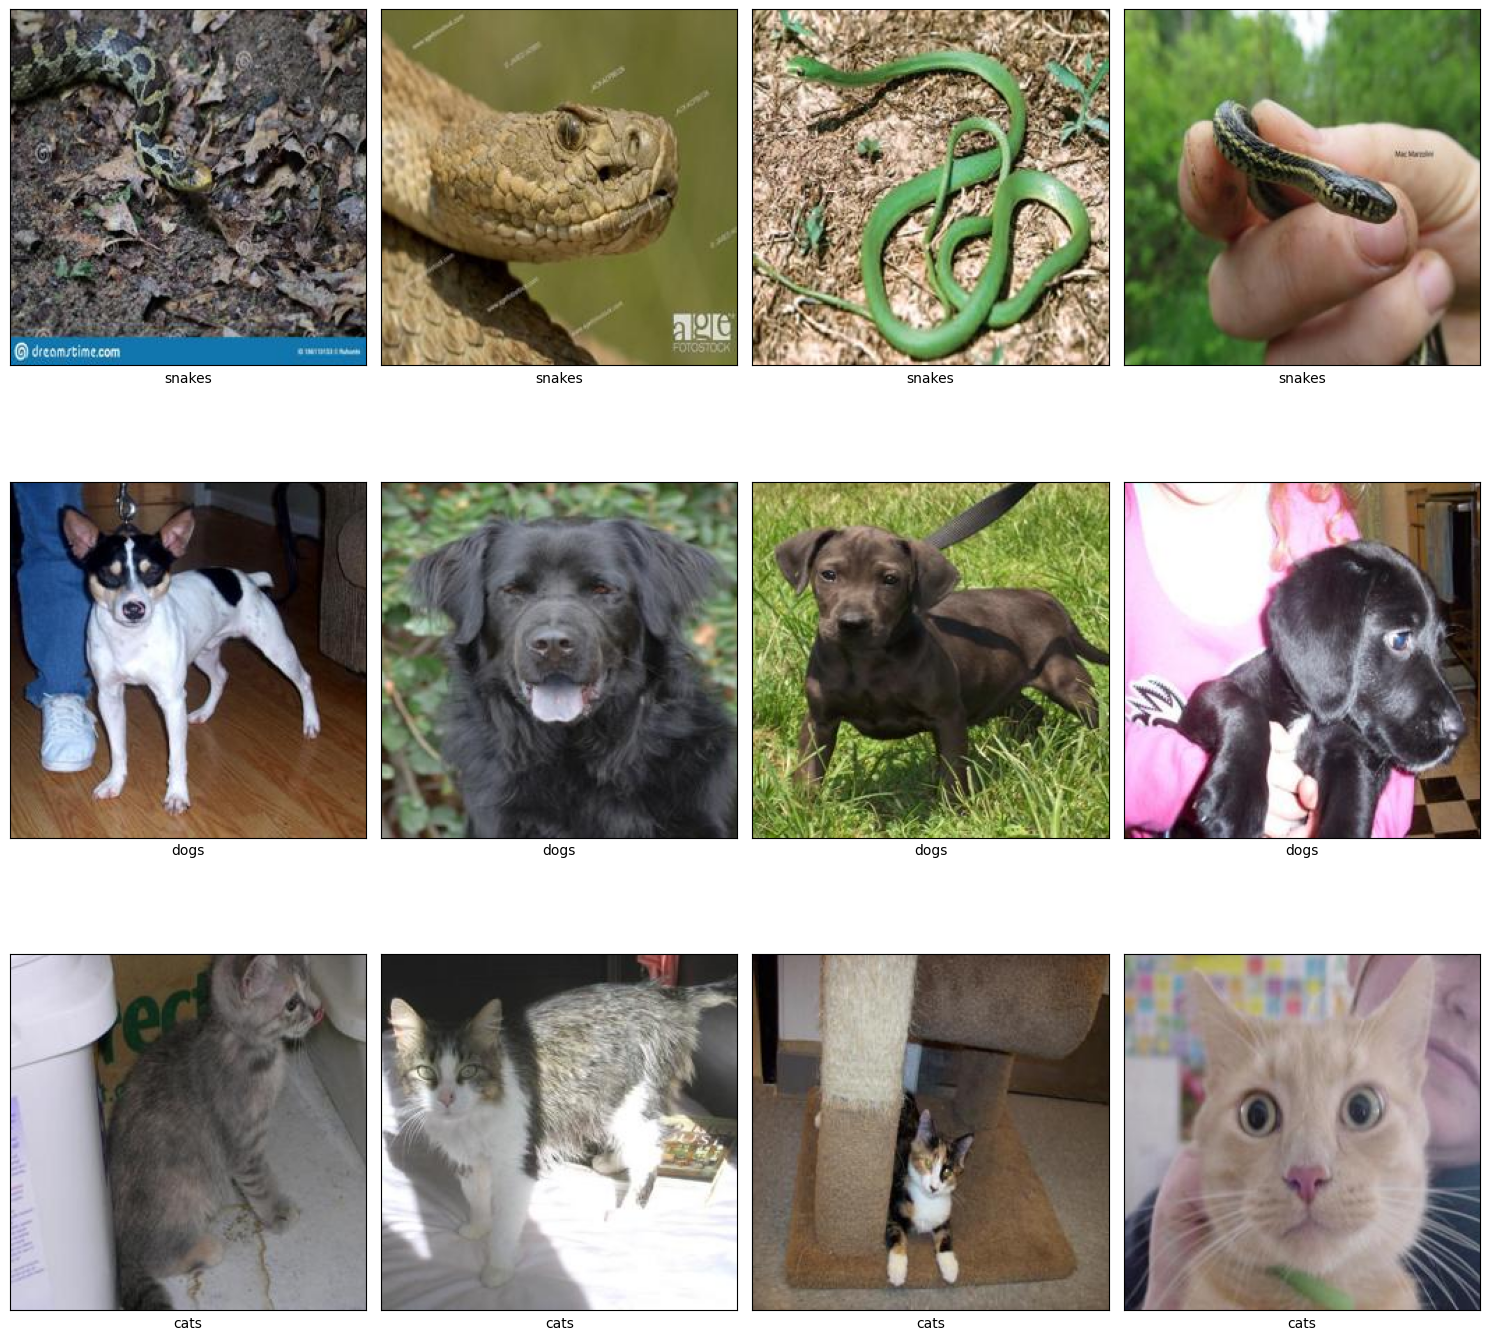

In [167]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
pet_image = {}

# Tentukan path sumber train
path = "/kaggle/input/animal-image-classification-dataset/"
path_sub = os.path.join(path, "Animals")
for i in os.listdir(path_sub):
    pet_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "/kaggle/input/animal-image-classification-dataset/Animals"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(pet_image.keys()), 4, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(pet_image[class_name], 4, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert('RGB')
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

In [168]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/kaggle/input/animal-image-classification-dataset/Animals/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah keseluruhan data gambar
display(len(df))
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

3000

labels
cats      1000
dogs      1000
snakes    1000
dtype: int64

In [169]:
df

path   file_name  labels
0     /kaggle/input/animal-image-classification-data...  2_0802.jpg  snakes
1     /kaggle/input/animal-image-classification-data...  2_0714.jpg  snakes
2     /kaggle/input/animal-image-classification-data...  2_0894.jpg  snakes
3     /kaggle/input/animal-image-classification-data...  2_0045.jpg  snakes
4     /kaggle/input/animal-image-classification-data...  2_0690.jpg  snakes
...                                                 ...         ...     ...
2995  /kaggle/input/animal-image-classification-data...  0_0651.jpg    cats
2996  /kaggle/input/animal-image-classification-data...  0_0468.jpg    cats
2997  /kaggle/input/animal-image-classification-data...  0_0798.jpg    cats
2998  /kaggle/input/animal-image-classification-data...  0_0322.jpg    cats
2999  /kaggle/input/animal-image-classification-data...  0_0506.jpg    cats

[3000 rows x 3 columns]

In [170]:
print(len(df['path']))
print(len(df['labels']))
print(len(df))

3000
3000
3000


In [171]:
# # cek datasetnya imbalanced nga?
# neg, pos = np.bincount(df['labels'])
# total = neg + pos
# print('Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
#     total, pos, 100 * pos / total))

### Data Preprocessing

#### Split Dataset

In [172]:
# Train:Validation:Test
# 80:10:10
# df_train, df_test = train_test_split(df[['path', 'labels']], test_size=0.1, random_state=42)

# 60:20:20
df_train, df_test = train_test_split(df[['path', 'labels']], test_size=0.2, random_state=42)

In [173]:
print('train size: ',len(df_train))
print('test size: ', len(df_test))

train size:  2400
test size:  600


In [174]:
# df_train_2, df_valid = train_test_split(df_train, train_size=0.9, random_state=42)
# df_train_2, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
# df_train2, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)
df_train_2, df_valid = train_test_split(df_train, train_size=0.8, random_state=42)

In [175]:
print('train size', len(df_train))
print('train size 2:', len(df_train_2))
print('test size' , len(df_test))
print('valid size', len(df_valid))

train size 2400
train size 2: 1920
test size 600
valid size 480


In [176]:
df_tr = pd.DataFrame({'path':df_train_2['path'],'labels':df_train_2['labels'],'set':'train'})
df_te = pd.DataFrame({'path':df_test['path'],'labels':df_test['labels'],'set':'test'})
df_va = pd.DataFrame({'path':df_valid['path'],'labels':df_valid['labels'],'set':'valid'})

In [177]:
print('train size:', len(df_tr))
print('test size:', len(df_te))
print('valid size:', len(df_va))

train size: 1920
test size: 600
valid size: 480


In [178]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_va], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   cats      186
       dogs      197
       snakes    217
train  cats      659
       dogs      633
       snakes    628
valid  cats      155
       dogs      170
       snakes    155
dtype: int64 


                                                   path  labels    set
2524  /kaggle/input/animal-image-classification-data...    dogs  valid
1297  /kaggle/input/animal-image-classification-data...  snakes  train
1897  /kaggle/input/animal-image-classification-data...    dogs  train
1764  /kaggle/input/animal-image-classification-data...    cats  train
2279  /kaggle/input/animal-image-classification-data...    dogs   test


In [179]:
df_all.set.value_counts()

set
train    1920
test      600
valid     480
Name: count, dtype: int64

#### Create dataset

In [180]:
!mkdir Dataset-Final-Animals
# !mkdir Dataset-Final-3

mkdir: cannot create directory ‘Dataset-Final-Animals’: File exists


In [181]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/kaggle/input/animal-image-classification-dataset/Animals/"
# datasource_path = "/content/train/train/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/kaggle/working/Dataset-Final-Animals"

In [182]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [183]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final-Animals/train/"
TEST_DIR = "Dataset-Final-Animals/test/"
VALID_DIR = "Dataset-Final-Animals/valid/"


print("Total class of images in training set:",len(os.listdir(TRAIN_DIR)))
print("Total class of images in testing set:",len(os.listdir(TEST_DIR)))
print("Total class of images in validation set:",len(os.listdir(VALID_DIR)))

Total class of images in training set: 3
Total class of images in testing set: 3
Total class of images in validation set: 3


In [184]:
# hyperparameter
batch_size = 32
epochs = 35
img_height, img_width, img_channels = 224, 224, 3
# img_height, img_width, img_channels = 144, 144, 3
width_shift_range, height_shift_range = 0.2, 0.2
shear_range = 0.2
zoom_range = 0.2
# zoom_range = [0.3, 0.4]
horizontal_flip, vertical_flip = True, True
rotation_range=20
rescale = 1./255
fill_mode = 'nearest'
validation_split = 0.2
'''
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
zca_epsilon=1e-06,
brightness_range=None,
channel_shift_range=0.0,
cval=0.0,
preprocessing_function=None,
data_format=None,
interpolation_order=1,
dtype=None
'''


'\nfeaturewise_center=False,\nsamplewise_center=False,\nfeaturewise_std_normalization=False,\nsamplewise_std_normalization=False,\nzca_whitening=False,\nzca_epsilon=1e-06,\nbrightness_range=None,\nchannel_shift_range=0.0,\ncval=0.0,\npreprocessing_function=None,\ndata_format=None,\ninterpolation_order=1,\ndtype=None\n'

In [185]:
# Create an ImageDataGenerator object normalizing the images
# rotation_range=[45,60]
datagen = ImageDataGenerator(rescale=rescale, rotation_range=rotation_range, zoom_range=zoom_range, 
                            horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                            width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                            shear_range=shear_range, fill_mode = fill_mode)
# valid_datagen = ImageDataGenerator(rescale=rescale)
test_datagen = ImageDataGenerator(rescale=rescale)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=batch_size,
                                              target_size=(img_height, img_width),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = test_datagen.flow_from_directory(VALID_DIR,
                                                   batch_size=batch_size,
                                                   target_size=(img_height, img_width),
                                                   class_mode='categorical',
                                                   # subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1920 images belonging to 3 classes.
Found 480 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [186]:
# Cek imbalanced dataset gaa
# Ambil semua label dari generator

labels = train_generator.classes  # array berisi label numerik, misal: [0, 0, 1, 2, 0, 1, ...]

# Hitung jumlah tiap kelas
counter = Counter(labels)

total = sum(counter.values())

# Cetak statistik per kelas
for class_idx, count in counter.items():
    percentage = 100 * count / total
    print(f"Class {class_idx}: {count} samples ({percentage:.2f}%)")

print(f"\nTotal: {total}")

Class 0: 659 samples (34.32%)
Class 1: 633 samples (32.97%)
Class 2: 628 samples (32.71%)

Total: 1920


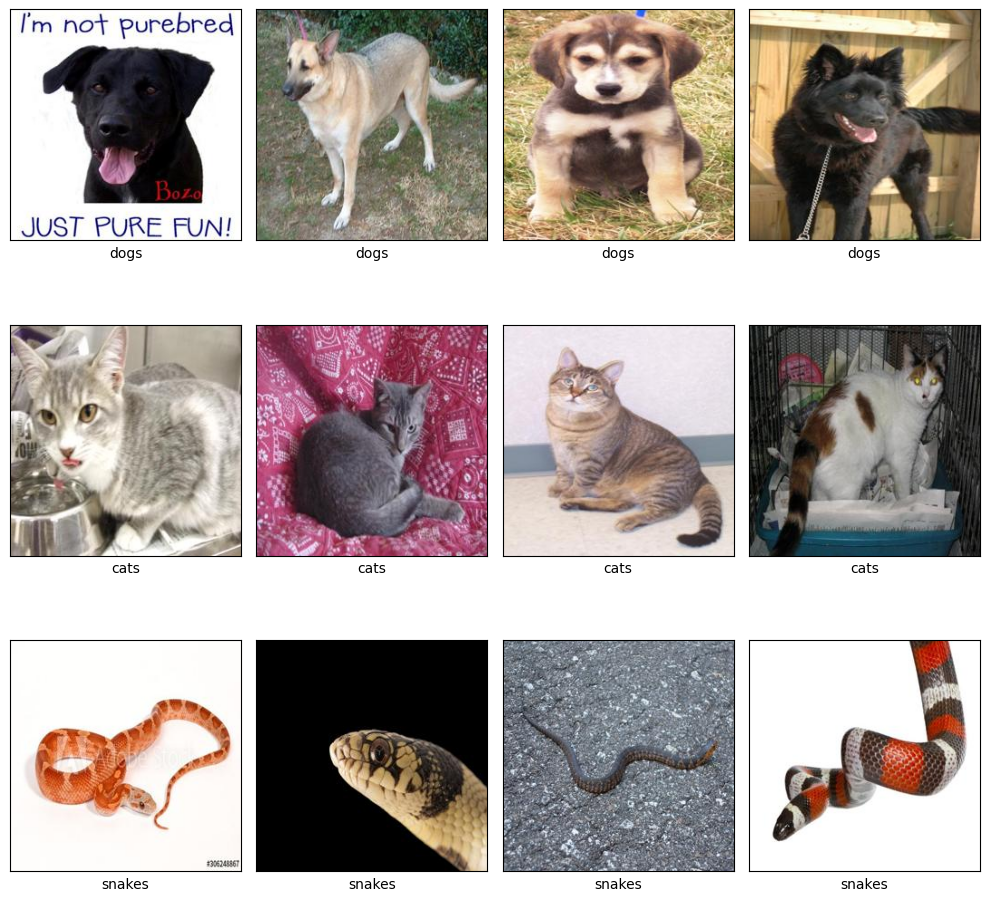

In [187]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
pet_image = {}

# Tentukan path sumber train
path = "/kaggle/working/"
path_sub = os.path.join(path, "Dataset-Final-Animals/train")
for i in os.listdir(path_sub):
    pet_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "/kaggle/working/Dataset-Final-Animals/train/"

fig, axs = plt.subplots(len(pet_image.keys()), 4, figsize=(10, 10))

for i, class_name in enumerate(os.listdir(path_sub)):
  if class_name in pet_image:
      images = np.random.choice(pet_image[class_name], 4, replace=False)

      for j, image_name in enumerate(images):
          img_path = os.path.join(path_sub, class_name, image_name)
          img = Image.open(img_path).convert('RGB')
          # img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
          axs[i, j].imshow(img)
          axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

## Modelling

### Transfer Learning

In [188]:
# Visual Geomerty Group
base_model_vgg = VGG19(input_shape=(img_height, img_width, img_channels), include_top=False,
                         weights='imagenet')

# Residual Network
base_model_resnet= ResNet152(input_shape=(img_height, img_width, img_channels), include_top=False,
                         weights='imagenet')

# Incepton
base_model_inc = InceptionV3(input_shape=(img_height, img_width, img_channels), include_top=False,
                         weights='imagenet')

# Xception
base_model_xcept = Xception(input_shape=(img_height, img_width, img_channels), include_top=False, weights='imagenet')

# DenseNet
base_model_denet = DenseNet201(input_shape=(img_height, img_width, img_channels), include_top=False, weights='imagenet')

# # MobileNet
# # base_model = MobileNetV2(input_shape=(img_height, img_width, img_channels),
# #                          include_top=False,
# #                          weights='imagenet')

In [189]:
# Freeze base model layers to no train
base_models = [base_model_vgg, base_model_resnet, base_model_inc, base_model_xcept, base_model_denet]
for base_model in base_models:
    for layer in base_model.layers:
        layer.trainable = False

In [240]:
# untuk cek apakah pasti false nggak di model tertentu
for base_model in base_models:
    print(base_model.name)
    print(base_model)
    for layer in base_model.layers[:5]:
        display(layer.trainable)

vgg19
<Functional name=vgg19, built=True>


False

False

False

False

False

resnet152
<Functional name=resnet152, built=True>


False

False

False

False

False

inception_v3
<Functional name=inception_v3, built=True>


False

False

False

False

False

xception
<Functional name=xception, built=True>


False

False

False

False

False

densenet201
<Functional name=densenet201, built=True>


False

False

False

False

False

### Create Model

In [192]:
# khusus MODEL Visual Geometry Group
def create_model_vgg(optimizer, train_gen, base_model):
    model = Sequential()
    # Flatten layer
    model.add(base_model)
    model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(train_gen.num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# untuk keseluruhan model
def create_model_base(optimizer, train_gen, base_model):
    model = Sequential()
    # Flatten layer
    model.add(base_model)
    model.add(Conv2D(2048, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(train_gen.num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [193]:
'''
model_adam = []
model_sgd = []
model_rms = []

for base_model in base_models:
    print(optimizer_adam)
    model_adam = create_model_base(optimizer_adam, train_generator, base_model)
    model_sgd = create_model_base(optimizer_SGD, train_generator, base_model)
    model_rms = create_model_base(optimizer_rms, train_generator, base_model)

    display(model_adam.summary())
    display(model_sgd.summary())
    display(model_rms.summary())
'''

# model_adam = create_model(optimizer_adam, train_generator)
# model_sgd = create_model(optimizer_SGD, train_generator)
# model_rms = create_model(optimizer_rms, train_generator)

# create manually karena harus explore looping dan array
# Visual Geomerty Group
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_adam_vgg = create_model_vgg(optimizer_adam, train_generator, base_models[0])
display(model_adam_vgg.summary())
# Residual Network
optimizer_adam_resnet = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_adam_resnet = create_model_base(optimizer_adam_resnet, train_generator, base_models[1])
display(model_adam_resnet.summary())
# Inception
optimizer_adam_inc = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_adam_inc = create_model_base(optimizer_adam_inc, train_generator, base_models[2])
display(model_adam_inc.summary())

optimizer_adam_xcept = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_adam_xcept = create_model_base(optimizer_adam_xcept, train_generator, base_models[3])
display(model_adam_xcept.summary())

optimizer_adam_denet = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_adam_denet = create_model_base(optimizer_adam_denet, train_generator, base_models[4])
display(model_adam_denet.summary())

# Visual Geomerty Group
optimizer_SGD_vgg = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_sgd_vgg = create_model_vgg(optimizer_SGD_vgg, train_generator, base_models[0])
display(model_sgd_vgg.summary())
# Residual Network
optimizer_SGD_resnet = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_sgd_resnet = create_model_base(optimizer_SGD_resnet, train_generator, base_models[1])
display(model_sgd_resnet.summary())
# Inception
optimizer_SGD_inc = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_sgd_inc = create_model_base(optimizer_SGD_inc, train_generator, base_models[2])
display(model_sgd_inc.summary())

optimizer_SGD_xcept = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_sgd_xcept = create_model_base(optimizer_SGD_xcept, train_generator, base_models[3])
display(model_sgd_xcept.summary())

optimizer_SGD_denet = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_sgd_denet = create_model_base(optimizer_SGD_denet, train_generator, base_models[4])
display(model_sgd_denet.summary())

# Visual Geomerty Group
optimizer_rms_vgg = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model_rms_vgg = create_model_vgg(optimizer_rms_vgg, train_generator, base_models[0])
display(model_rms_vgg.summary())
# Residual Network
optimizer_rms_resnet = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model_rms_resnet = create_model_base(optimizer_rms_resnet, train_generator, base_models[1])
display(model_rms_resnet.summary())
# Inception
optimizer_rms_inc = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model_rms_inc = create_model_base(optimizer_rms_inc, train_generator, base_models[2])
display(model_rms_inc.summary())

optimizer_rms_xcept = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model_rms_xcept = create_model_base(optimizer_rms_xcept, train_generator, base_models[3])
display(model_rms_xcept.summary())

optimizer_rms_denet = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model_rms_denet = create_model_base(optimizer_rms_denet, train_generator, base_models[4])
display(model_rms_denet.summary())

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_658 (Conv2D)                  │ (None, 7, 7, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_727              │ (None, 7, 7, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_94 (MaxPooling2D)      │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_69 (Flatten)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_728              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,109,443 (103.41 MB)

 Trainable params: 7,082,499 (27.02 MB)

 Non-trainable params: 20,026,944 (76.40 MB)

None

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)               │ (None, 7, 7, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_659 (Conv2D)                  │ (None, 7, 7, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_729              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_95 (MaxPooling2D)      │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_70 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_730              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,850,563 (384.71 MB)

 Trainable params: 42,475,011 (162.03 MB)

 Non-trainable params: 58,375,552 (222.69 MB)

None

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_660 (Conv2D)                  │ (None, 5, 5, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_731              │ (None, 5, 5, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_96 (MaxPooling2D)      │ (None, 2, 2, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_71 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_732              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,660,963 (235.22 MB)

 Trainable params: 39,853,571 (152.03 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

None

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_661 (Conv2D)                  │ (None, 7, 7, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_733              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_97 (MaxPooling2D)      │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_72 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_734              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,341,099 (241.63 MB)

 Trainable params: 42,475,011 (162.03 MB)

 Non-trainable params: 20,866,088 (79.60 MB)

None

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_662 (Conv2D)                  │ (None, 7, 7, 2048)          │      35,391,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_735              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_98 (MaxPooling2D)      │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_73 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_736              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,442,307 (222.94 MB)

 Trainable params: 40,115,715 (153.03 MB)

 Non-trainable params: 18,326,592 (69.91 MB)

None

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_663 (Conv2D)                  │ (None, 7, 7, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_737              │ (None, 7, 7, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_99 (MaxPooling2D)      │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_74 (Flatten)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_738              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,109,443 (103.41 MB)

 Trainable params: 7,082,499 (27.02 MB)

 Non-trainable params: 20,026,944 (76.40 MB)

None

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)               │ (None, 7, 7, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_664 (Conv2D)                  │ (None, 7, 7, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_739              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_100 (MaxPooling2D)     │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_75 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_740              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,850,563 (384.71 MB)

 Trainable params: 42,475,011 (162.03 MB)

 Non-trainable params: 58,375,552 (222.69 MB)

None

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_665 (Conv2D)                  │ (None, 5, 5, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_741              │ (None, 5, 5, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_101 (MaxPooling2D)     │ (None, 2, 2, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_76 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_742              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,660,963 (235.22 MB)

 Trainable params: 39,853,571 (152.03 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

None

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_666 (Conv2D)                  │ (None, 7, 7, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_743              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_102 (MaxPooling2D)     │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_77 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_744              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,341,099 (241.63 MB)

 Trainable params: 42,475,011 (162.03 MB)

 Non-trainable params: 20,866,088 (79.60 MB)

None

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_667 (Conv2D)                  │ (None, 7, 7, 2048)          │      35,391,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_745              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_103 (MaxPooling2D)     │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_78 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_746              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,442,307 (222.94 MB)

 Trainable params: 40,115,715 (153.03 MB)

 Non-trainable params: 18,326,592 (69.91 MB)

None

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_668 (Conv2D)                  │ (None, 7, 7, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_747              │ (None, 7, 7, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_104 (MaxPooling2D)     │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_79 (Flatten)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_748              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,109,443 (103.41 MB)

 Trainable params: 7,082,499 (27.02 MB)

 Non-trainable params: 20,026,944 (76.40 MB)

None

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)               │ (None, 7, 7, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_669 (Conv2D)                  │ (None, 7, 7, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_749              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_105 (MaxPooling2D)     │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_80 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_750              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,850,563 (384.71 MB)

 Trainable params: 42,475,011 (162.03 MB)

 Non-trainable params: 58,375,552 (222.69 MB)

None

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_670 (Conv2D)                  │ (None, 5, 5, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_751              │ (None, 5, 5, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_106 (MaxPooling2D)     │ (None, 2, 2, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_81 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_752              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,660,963 (235.22 MB)

 Trainable params: 39,853,571 (152.03 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

None

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_671 (Conv2D)                  │ (None, 7, 7, 2048)          │      37,750,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_753              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_107 (MaxPooling2D)     │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_82 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_754              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,341,099 (241.63 MB)

 Trainable params: 42,475,011 (162.03 MB)

 Non-trainable params: 20,866,088 (79.60 MB)

None

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_672 (Conv2D)                  │ (None, 7, 7, 2048)          │      35,391,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_755              │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_108 (MaxPooling2D)     │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_83 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_756              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,442,307 (222.94 MB)

 Trainable params: 40,115,715 (153.03 MB)

 Non-trainable params: 18,326,592 (69.91 MB)

None

In [194]:
# untuk handle imbalanced dataset
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [195]:
# Callbacks
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
 
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

### Using Transfer Learning Models with Adam Optimizer

In [196]:
# history_1 = []
# for i in range(len(base_models)):
#     print(base_models[i] + "\n")
#     history_1 = model_adam.fit(train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     callbacks=[early_stopping])

# Visual Geometry Group
print("Visual Geometry Group Model")
history_vgg_1 = model_adam_vgg.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

# Residual Network
print("Residual Network Model")
history_resnet_1 = model_adam_resnet.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

# Inception
print("Inception (GoogLeNet) Model")
history_incept_1 = model_adam_inc.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

print("Xception Model")
history_xcept_1 = model_adam_xcept.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

print("DenseNet Model")
history_denet_1 = model_adam_denet.fit(train_generator, 
                                       epochs=epochs, 
                                       validation_data=validation_generator,
                                       callbacks=[early_stopping])
print("\n")

Visual Geometry Group Model
Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 436ms/step - accuracy: 0.5646 - loss: 1.0157 - val_accuracy: 0.8042 - val_loss: 0.5559
Epoch 2/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.7547 - loss: 0.6017 - val_accuracy: 0.8604 - val_loss: 0.4524
Epoch 3/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 388ms/step - accuracy: 0.7660 - loss: 0.5617 - val_accuracy: 0.8729 - val_loss: 0.4178
Epoch 4/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 385ms/step - accuracy: 0.7964 - loss: 0.4530 - val_accuracy: 0.8583 - val_loss: 0.3709
Epoch 5/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.7993 - loss: 0.4345 - val_accuracy: 0.8625 - val_loss: 0.3416
Epoch 6/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 385ms/step - accuracy: 0.8078 - loss: 0.4620 - val_accuracy: 0.8896 - val_loss: 0.2750
Epoch 7/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.8361 - loss: 0.3882 - val_accuracy: 0.9167 - val_loss: 0.2441
Epoch 8/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 380ms/step - accuracy: 0.8284 - loss: 0.4053 - val_accuracy: 0.908

### Using Transfer Learning Models with RMS Optimizer

In [197]:
# Visual Geomerty Group
print("Visual Geometry Group Model")
history_vgg_2 = model_rms_vgg.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

# Residual Network
print("Residual Network Model")
history_resnet_2 = model_rms_resnet.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

# Inception
print("Inception (GoogLeNet) Model")
history_incept_2 = model_rms_inc.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

# Xception
print("Xception Model")
history_xcept_2 = model_rms_xcept.fit(train_generator, 
                                      epochs=epochs, 
                                      validation_data=validation_generator, 
                                      callbacks=[early_stopping])
print("\n")

print("DenseNet Model")
history_denet_2 = model_rms_denet.fit(train_generator, 
                                      epochs=epochs, 
                                      validation_data=validation_generator,
                                      callbacks=[early_stopping])
print("\n")

Visual Geometry Group Model
Epoch 1/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 407ms/step - accuracy: 0.5469 - loss: 1.0299 - val_accuracy: 0.8208 - val_loss: 0.6029
Epoch 2/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 392ms/step - accuracy: 0.7387 - loss: 0.6288 - val_accuracy: 0.8562 - val_loss: 0.4740
Epoch 3/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 385ms/step - accuracy: 0.7547 - loss: 0.5579 - val_accuracy: 0.8208 - val_loss: 0.4352
Epoch 4/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.7856 - loss: 0.4918 - val_accuracy: 0.7958 - val_loss: 0.4285
Epoch 5/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 388ms/step - accuracy: 0.8188 - loss: 0.4442 - val_accuracy: 0.8750 - val_loss: 0.3073
Epoch 6/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.8086 - loss: 0.4304 - val_accuracy: 0.8854 - val_loss: 0.2572
Epoch 7/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.8204 - loss: 0.4098 - val_accuracy: 0.8917 - val_loss: 0.2470
Epoch 8/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.83

### Using Transfer Learning Models with SGD Optimizer

In [198]:
# Visual Geomerty Group
print("Visual Geometry Group Model")
history_vgg_3 = model_sgd_vgg.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

# Residual Network
print("Residual Network Model")
history_resnet_3 = model_sgd_resnet.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

# Inception
print("Inception (GoogLeNet) Model")
history_incept_3 = model_sgd_inc.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])
print("\n")

print("Xception Model")
history_xcept_3 = model_sgd_xcept.fit(train_generator, 
                                      epochs=epochs, 
                                      validation_data=validation_generator, 
                                      callbacks=[early_stopping])
print("\n") 

print("DenseNet Model")
history_denet_3 = model_sgd_denet.fit(train_generator, 
                                      epochs=epochs, 
                                      validation_data=validation_generator, 
                                      callbacks=[early_stopping])
print("\n") 

Visual Geometry Group Model
Epoch 1/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 447ms/step - accuracy: 0.3756 - loss: 1.5488 - val_accuracy: 0.4333 - val_loss: 1.0584
Epoch 2/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 401ms/step - accuracy: 0.4567 - loss: 1.2841 - val_accuracy: 0.5396 - val_loss: 1.0034
Epoch 3/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 400ms/step - accuracy: 0.4805 - loss: 1.1763 - val_accuracy: 0.6042 - val_loss: 0.9344
Epoch 4/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.5560 - loss: 1.0423 - val_accuracy: 0.6438 - val_loss: 0.8588
Epoch 5/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.5358 - loss: 1.0741 - val_accuracy: 0.6917 - val_loss: 0.7795
Epoch 6/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.5509 - loss: 1.0259 - val_accuracy: 0.6896 - val_loss: 0.7226
Epoch 7/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.5426 - loss: 1.0395 - val_accuracy: 0.7125 - val_loss: 0.6563
Epoch 8/35
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.59

## Evaluasi dan Visualisasi

### Memilih optimizer dan Transfer Learning model berdasarkan akurasi training dan validation tertinggi untuk menggambarkan visualisasinya.
Pilih: Model Inception dengan RMSProps Optimizer

In [199]:
def create_visualization(history, optimizer):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    print(optimizer)
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training and Validation Loss')
    plt.show()

Incept - Adam


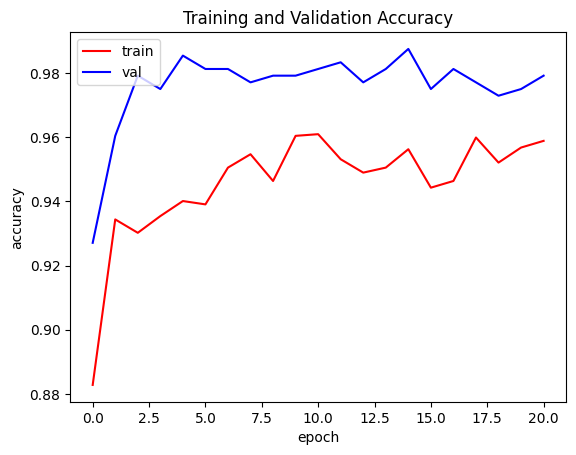

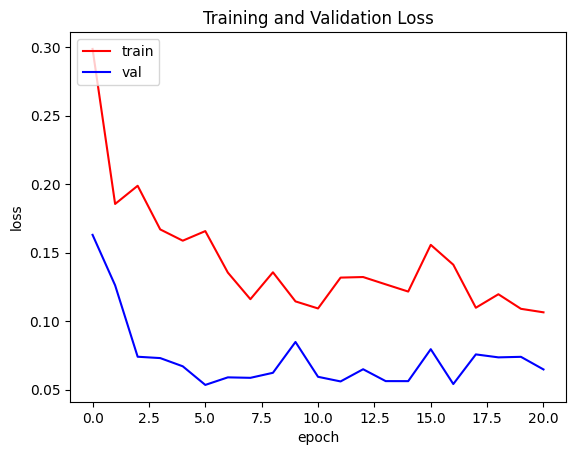

Xception - Adam


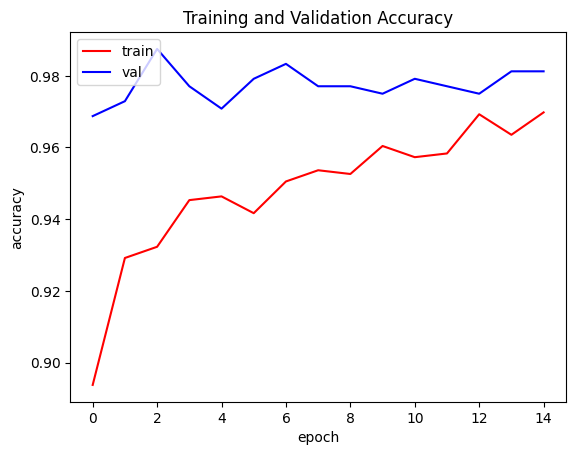

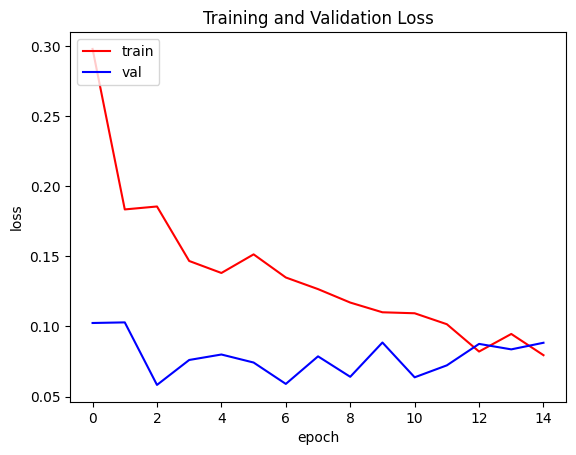

DenseNet - Adam


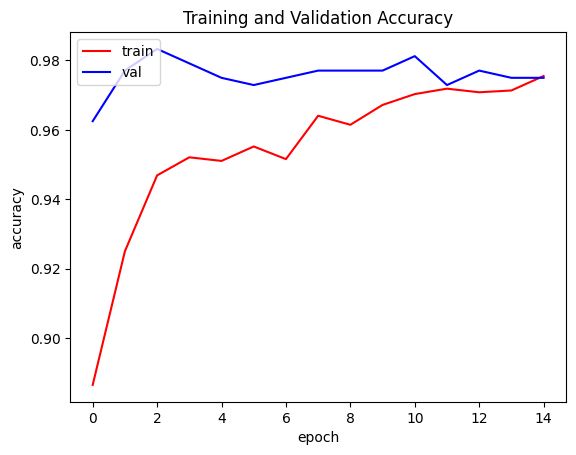

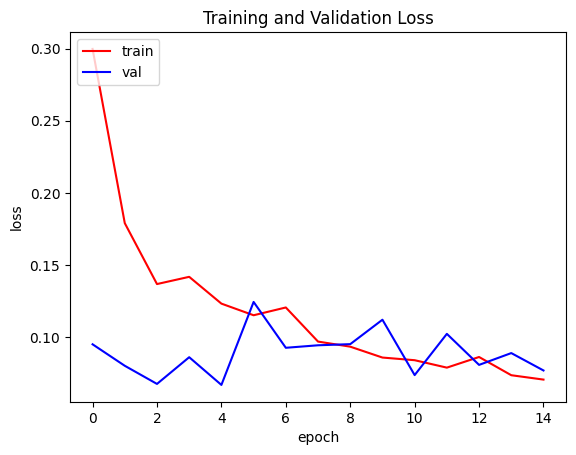

Incept - RMSProp


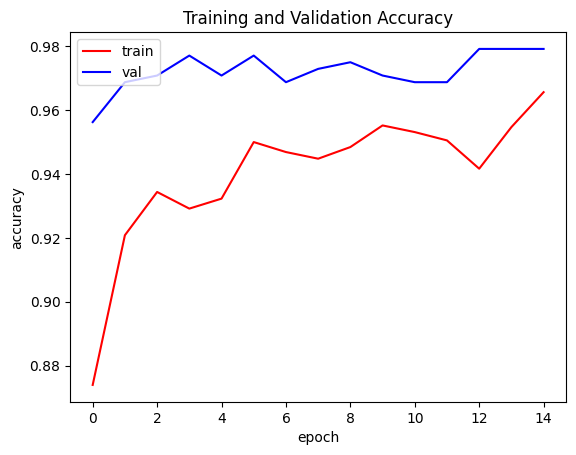

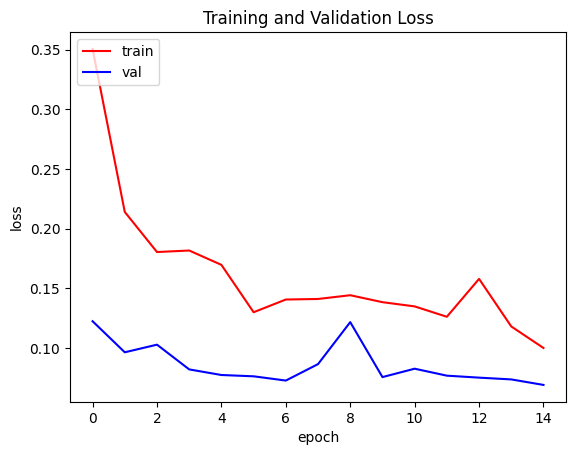

Xception - RMSProp


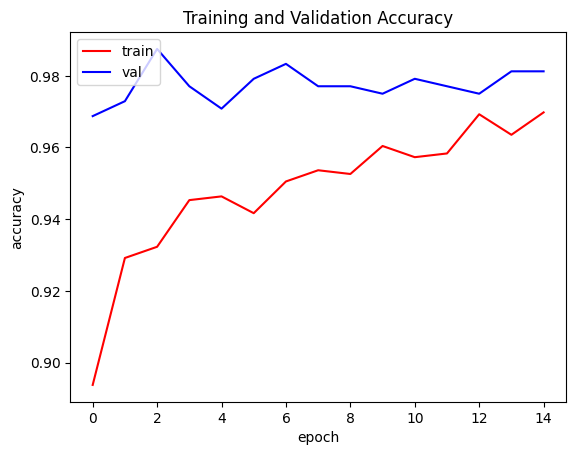

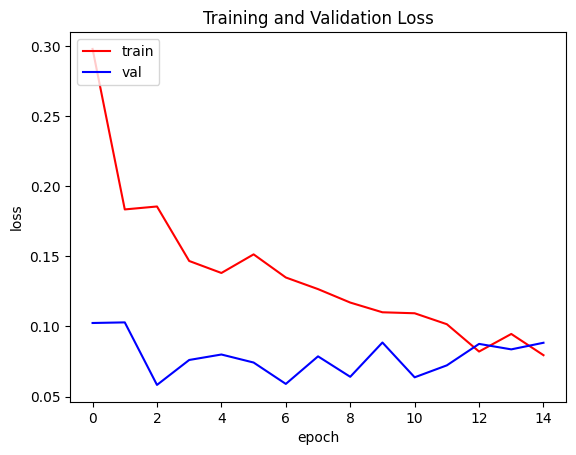

DenseNet - RMSProp


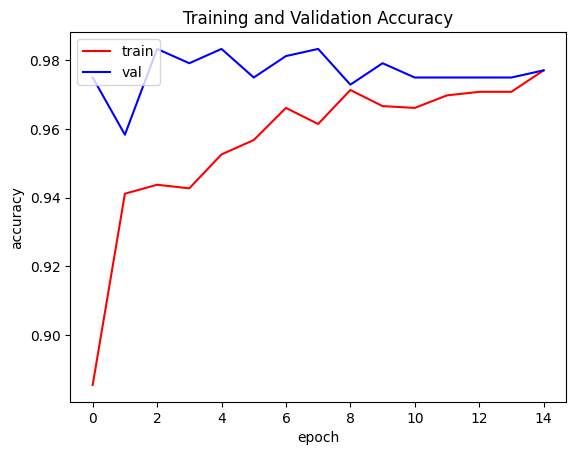

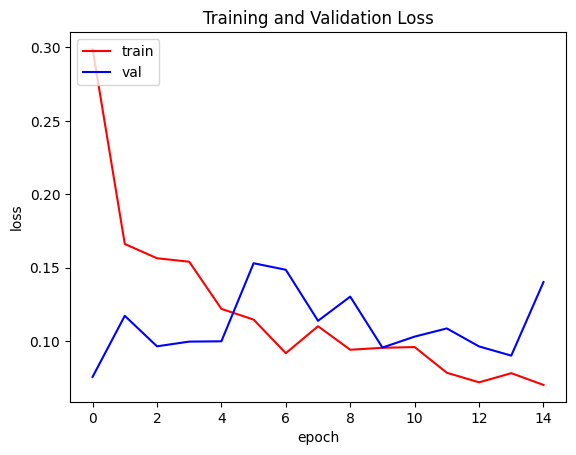

In [214]:
print("Incept - Adam")
create_visualization(history_incept_1, optimizer_adam_inc)
print("Xception - Adam")
create_visualization(history_xcept_1, optimizer_adam_xcept)
print("DenseNet - Adam")
create_visualization(history_denet_1, optimizer_adam_denet)
print("Incept - RMSProp")
create_visualization(history_incept_2, optimizer_rms_inc)
print("Xception - RMSProp")
create_visualization(history_xcept_1, optimizer_rms_xcept)
print("DenseNet - RMSProp")
create_visualization(history_denet_2, optimizer_rms_denet)

Berdasarkan hasil pengamatan visualisasi di atas, model DenseNet dan Adam Optimizer lebih baik



              precision    recall  f1-score   support

           0     0.9158    0.9946    0.9536       186
           1     0.9891    0.9188    0.9526       197
           2     0.9953    0.9862    0.9907       217

    accuracy                         0.9667       600
   macro avg     0.9668    0.9665    0.9657       600
weighted avg     0.9686    0.9667    0.9667       600



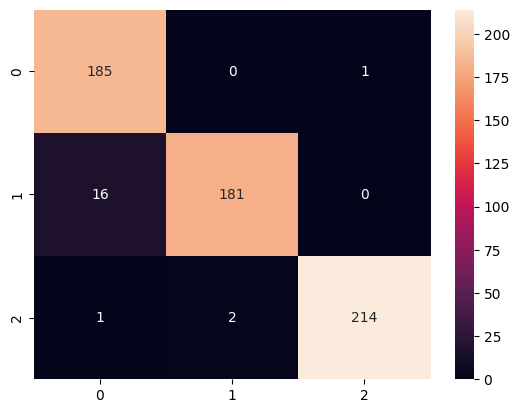

In [215]:
test_generator.reset()

def confm(test_gen, model):
    preds = model.predict(test_gen,verbose=0)

    # Print Confusion Matrix
    predicted_classes = np.argmax(preds, axis=1)

    # Print Confusion Matrix
    cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_classes))
    sns.heatmap(cm,annot=True,fmt="d")

    # Print Classification Report
    print("\n")
    print(classification_report(y_true=test_gen.classes,y_pred=predicted_classes, digits=4))

# confm(test_generator, model_adam_incept)
confm(test_generator, model_adam_denet)
# confm(test_generator, model_rms_inc)
# confm(test_generator, model_sgd_incept)

In [216]:
def eval_test(test_gen, model):
    evaluation_test = model.evaluate(
        test_gen,
        steps=test_gen.samples)
    return evaluation_test
# eval_test_adam = eval_test(test_generator, model_adam_inc)
eval_test_adam = eval_test(test_generator, model_adam_denet)
# eval_test_rms = eval_test(test_generator, model_rms_inc)
# eval_test_sgd = eval_test(test_generator, model_sgd_incept)

600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9708 - loss: 0.0798


In [217]:
display(eval_test_adam)
# display(eval_test_rms)
# display(eval_test_sgd)

[0.10189203917980194, 0.9666666388511658]

In [218]:
# Menampilkan hasil evaluasi test
print("Loss - Adam:", eval_test_adam[0] * 100)
print("Accuracy - Adam:", eval_test_adam[1] * 100)

# print("Loss - RMS:", eval_test_rms[0] * 100)
# print("Accuracy - RMS:", eval_test_rms[1] * 100)

# print("Loss - SGD:", eval_test_sgd[0] * 100)
# print("Accuracy - SGD:", eval_test_sgd[1] * 100)

Loss - Adam: 10.189203917980194
Accuracy - Adam: 96.66666388511658


### Prediksi Gambar

In [224]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of Class: {0} \nSpecies: {1}'.format(clas, name))

In [225]:
test_image = '/kaggle/working/Dataset-Final-Animals/test/dogs/1_0063.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The given image is of Class: 1 
Species: dogs


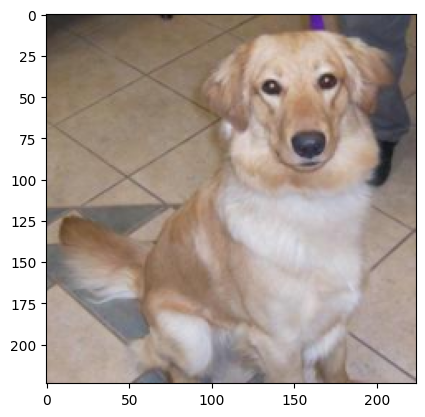

In [226]:
predictor(test_image, model_rms_inc) #example image

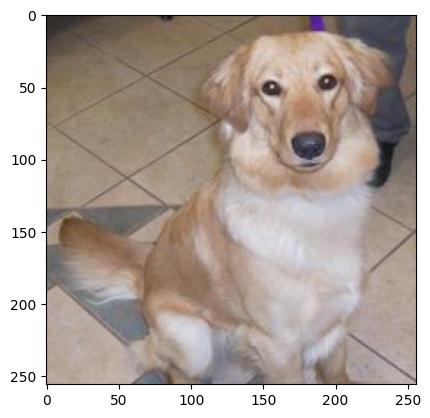

In [227]:
img = mpimg.imread(test_image)
imgplot = plt.imshow(img)
plt.show()

## Konversi Model

### Saved Model

In [209]:
!mkdir saved-model

In [229]:
save_path = '/kaggle/working/saved-model/'
tf.saved_model.save(model_adam_denet, save_path)

In [228]:
model_rms_inc.save('/kaggle/working/saved-model/model_adam_denet.h5')
print("Model with h5 is now saved!")

Model with h5 is now saved!


In [232]:
get_model = load_model('/kaggle/working/saved-model/model_adam_denet.h5')
if get_model != None:
    print("Model loaded successfully!")
else:
    print("Failed to load the model.")

Model loaded successfully!


### TensorFlow.js

In [233]:
!mkdir tfjs_model

In [234]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [235]:
# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras "/kaggle/working/saved-model/model_adam_denet.h5" tfjs_model

2025-05-21 09:32:39.300363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747819959.321544    3971 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747819959.328054    3971 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


### TensorFlow Lite

In [236]:
!mkdir tflite

In [237]:
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/kaggle/working/tflite/model_adam_denet.tflite')
tflite_model_file.write_bytes(tflite_model)

W0000 00:00:1747820115.087345      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747820115.087391      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747820115.494079      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


835904

In [238]:
import shutil
directory_saved = '/kaggle/working/saved-model'
directory_tfjs = '/kaggle/working/tfjs_model'
shutil.make_archive('saved-model', 'zip', directory_saved)
shutil.make_archive('tfjs_model', 'zip', directory_tfjs)

'/kaggle/working/tfjs_model.zip'